In [228]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from scipy.ndimage import correlate
Epsilon = 1e-7
DPI = 120
RADIUS = 2
THICKNESS = 2
COLOR = [255,0,0]

### load image and compute the gradient

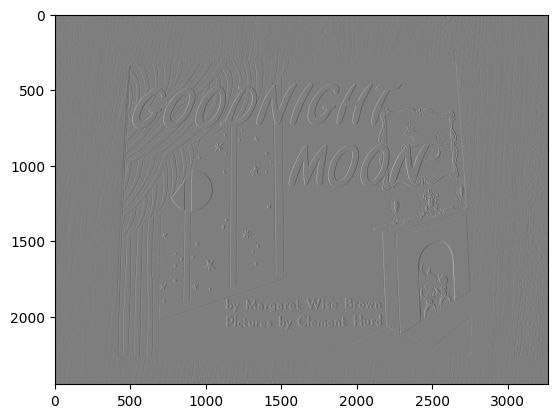

In [229]:
# TODO 
input_img = cv2.imread('inputs/I1.jpg', 0) / 255
dy, dx = cv2.Sobel(input_img, cv2.CV_64F, 0, 1), cv2.Sobel(input_img, cv2.CV_64F, 1, 0)
plt.imshow(dx, cmap='gray')

### Compute structure tensor

In [230]:
# Compute the structure tensor
def compute_structure_tensor(img):
    '''
    Compute the structure tensor of the input image
    :param img: input image
    :return: Ixx, Ixy, Iyy
    '''
    dy, dx = cv2.Sobel(img, cv2.CV_64F, 0, 1), cv2.Sobel(img, cv2.CV_64F, 1, 0)
    Ixx = dx**2
    Ixy = dx * dy
    Iyy = dy**2
    return Ixx, Ixy, Iyy

### Compute Shi-Thomasi response and Harris response, please compare them in the end

In [231]:
from numpy import linalg as LA

def calculate_response_shitomasi(img, sigma=1):
    """
    Compute the Shi-Thomasi response map
    :param img: input image
    :param sigma: filter size
    :return: response map
    """
    # Compute the structure tensor
    Ixx, Ixy, Iyy = compute_structure_tensor(img)

    # Apply Gaussian filter for response window
    Gxx = gaussian_filter(Ixx, sigma)
    Gxy = gaussian_filter(Ixy, sigma)
    Gyy = gaussian_filter(Iyy, sigma)

    # Tensor matrix M
    M = np.array([[Gxx, Gxy], [Gxy, Gyy]])

    # Calculate the two eigenvalues of M
    trace = Gxx + Gyy
    det = Gxx * Gyy - Gxy**2
    eig1 = 0.5 * (trace + np.sqrt(trace**2 - 4 * det))
    eig2 = 0.5 * (trace - np.sqrt(trace**2 - 4 * det))

    # The response for the Shi-Tomasi method is the minimum of the two eigenvalues.
    response = np.minimum(eig1, eig2)

    return response

def calculate_response_harris(img, k=0.05, sigma=1):
    """
    Compute the Harris response map
    :param img: input image
    :param window_size: size of the window
    :param k: Harris constant
    :return: Harris response map
    """
    # Compute the structure tensor
    Ixx, Ixy, Iyy = compute_structure_tensor(img)

    # Apply Gaussian filter for response window
    Gxx = gaussian_filter(Ixx, sigma)
    Gxy = gaussian_filter(Ixy, sigma)
    Gyy = gaussian_filter(Iyy, sigma)

    # Tensor matrix M
    M = np.array([[Gxx, Gxy], [Gxy, Gyy]])

    # Calculate determinant and trace of the matrix
    det_M = Gxx * Gyy - Gxy**2
    trace_M = Gxx + Gyy

    # Use Harris formulation: response = det(M) - k*(trace(M))^2
    response = det_M - k * (trace_M)**2

    return response

# Compute the Shi-Thomasi and Harris response
response_shitomasi = calculate_response_shitomasi(input_img)
response_harris = calculate_response_harris(input_img)

### Visualise the response map

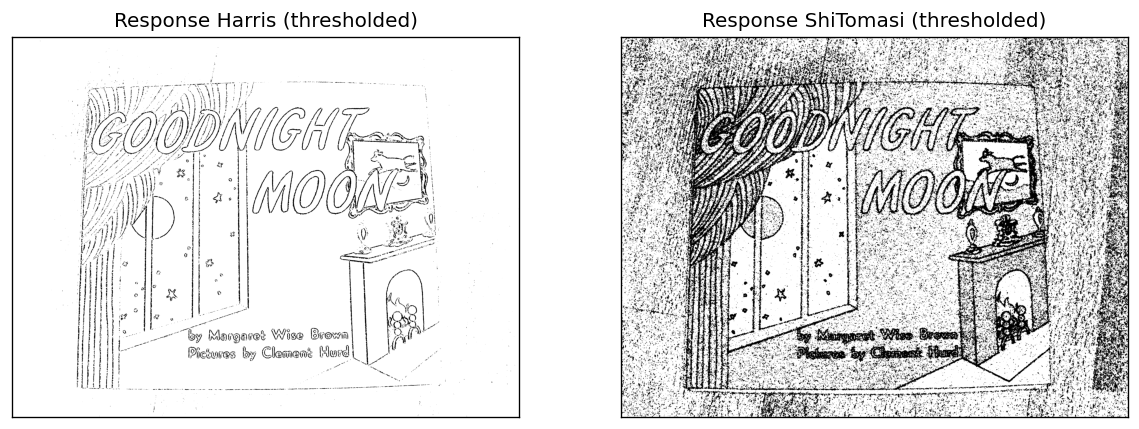

In [232]:
# choose either Shi-Tomasi or Harris response
response_harris_thresh = np.zeros_like(response_harris)
response_harris_thresh[response_harris > np.mean(response_harris)] = 255

response_shitomasi_thresh = np.zeros_like(response_shitomasi)
response_shitomasi_thresh[response_shitomasi < np.mean(response_shitomasi)] = 255

# from now on use harris
response = response_harris

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(response_harris_thresh, cmap = 'gray')
plt.title('Response Harris (thresholded)')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(response_shitomasi_thresh, cmap=plt.cm.gray)
plt.title('Response ShiTomasi (thresholded)')
plt.show()

### Plot the histogram of responses

(array([6.049816e+06, 5.400020e+05, 2.220720e+05, 1.242670e+05,
        8.053200e+04, 5.687800e+04, 4.263900e+04, 3.370400e+04,
        2.712600e+04, 2.267300e+04, 1.893800e+04, 1.644300e+04,
        1.408800e+04, 1.260800e+04, 1.124000e+04, 1.007200e+04,
        9.191000e+03, 8.428000e+03, 7.451000e+03, 6.972000e+03,
        6.260000e+03, 6.016000e+03, 5.527000e+03, 5.326000e+03,
        4.708000e+03, 4.507000e+03, 4.268000e+03, 3.956000e+03,
        3.757000e+03, 3.566000e+03]),
 array([0.00000000e+00, 3.33333333e-06, 6.66666667e-06, 1.00000000e-05,
        1.33333333e-05, 1.66666667e-05, 2.00000000e-05, 2.33333333e-05,
        2.66666667e-05, 3.00000000e-05, 3.33333333e-05, 3.66666667e-05,
        4.00000000e-05, 4.33333333e-05, 4.66666667e-05, 5.00000000e-05,
        5.33333333e-05, 5.66666667e-05, 6.00000000e-05, 6.33333333e-05,
        6.66666667e-05, 7.00000000e-05, 7.33333333e-05, 7.66666667e-05,
        8.00000000e-05, 8.33333333e-05, 8.66666667e-05, 9.00000000e-05,
        9.

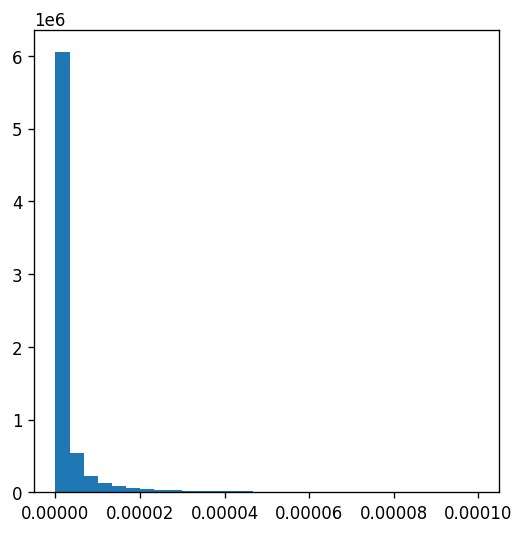

In [233]:
plt.figure(figsize=(5,5), dpi=DPI)
plt.hist(response.flatten()[response.flatten()>0], range=(0, 0.0001), bins=30)

### Threshold the corners and visualise it

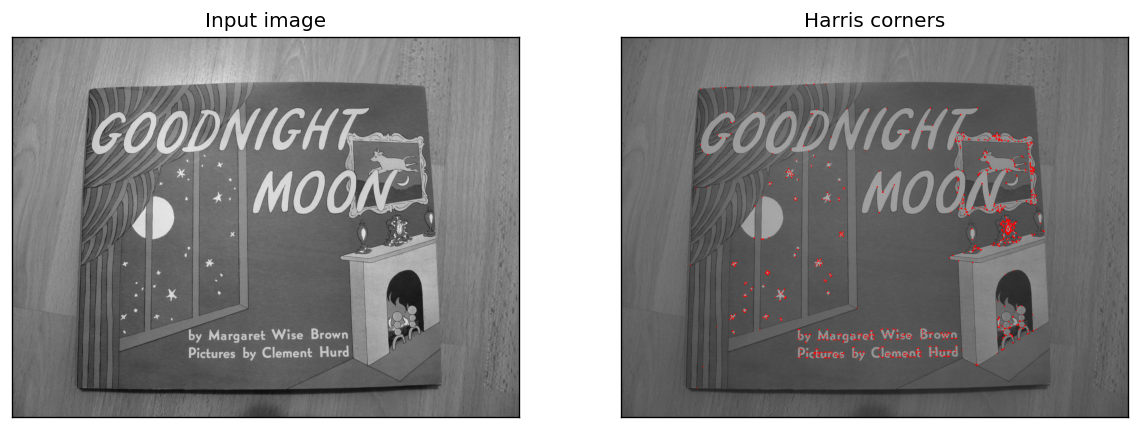

In [234]:
# TODO 
threshold = 0.4e-2

corners =  cv2.cvtColor((input_img.copy() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
mask = response>threshold

x, y = np.where(mask)
for idx in range(len(x)):
    cv2.circle(corners, (y[idx],x[idx]), RADIUS, COLOR, THICKNESS)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow((input_img * 255).astype(np.uint8), cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(corners)
plt.title('Harris corners')
plt.show()

### Apply NMS

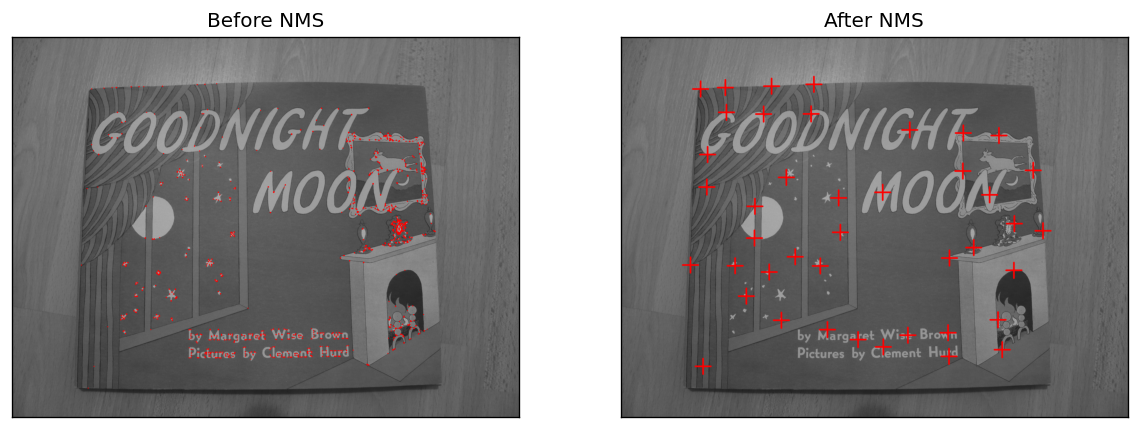

In [235]:
from scipy.ndimage import maximum_filter

LINE_LENGTH = 50
COLOR = (255, 0, 0)  # Example color
THICKNESS = 10  # Example thickness

# Make mask from maximum filter and threshold
mask = (response == maximum_filter(response, size=300)) & (response > threshold)

corners_filter =  cv2.cvtColor((input_img.copy() * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

x, y = np.where(mask)

#for idx in range(len(x)):
#    cv2.circle(corners_filter, (y[idx],x[idx]), RADIUS, COLOR, thickness=40)

for idx in range(len(x)):
    cv2.line(corners_filter, (y[idx] - LINE_LENGTH, x[idx]), (y[idx] + LINE_LENGTH, x[idx]), COLOR, THICKNESS)
    cv2.line(corners_filter, (y[idx], x[idx] - LINE_LENGTH), (y[idx], x[idx] + LINE_LENGTH), COLOR, THICKNESS)


plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(corners)
plt.title('Before NMS')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(corners_filter)
plt.title('After NMS')
plt.show()

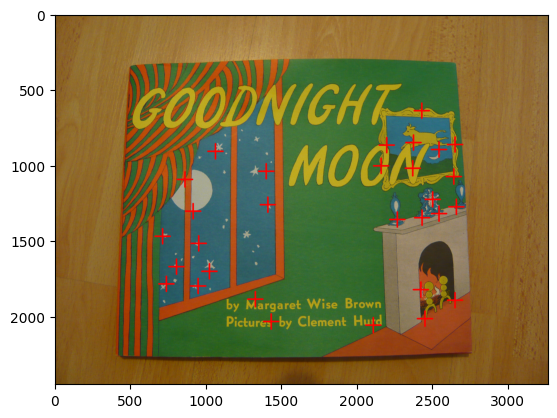

(<matplotlib.image.AxesImage at 0x15faeaf90>, None)

In [236]:
img = cv2.imread('inputs/I1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray, 30, 0.5, 100)
corners = np.intp(corners)

for i in corners:
    x, y = i.ravel()
    cv2.line(img, (x - LINE_LENGTH, y), (x + LINE_LENGTH, y), COLOR, THICKNESS)
    cv2.line(img, (x, y - LINE_LENGTH), (x, y + LINE_LENGTH), COLOR, THICKNESS)

plt.imshow(img), plt.show()